In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from scipy.stats import norm, skew
from scipy import stats
import seaborn as sns

In [2]:
df1_i = pd.read_csv('raw_account_70_new.csv')
df1_t = pd.read_csv('raw_account_30_new.csv')
df2_i = pd.read_csv('raw_data_70_new.csv')
df2_t = pd.read_csv('raw_data_30_new.csv')
df3_i = pd.read_csv('raw_enquiry_70_new.csv')
df3_t = pd.read_csv('raw_enquiry_30_new.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (12,20,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#removing customer number repitition
c_1 = df1_i['customer_no'] + 13000
c_2 = df2_i['customer_no'] + 13000
c_3 = df3_i['customer_no'] + 13000
df1_i['customer_no'] = c_1
df2_i['customer_no'] = c_2
df3_i['customer_no'] = c_3


len_1 = len(df1_i)
len_2 = len(df2_i)
len_3 = len(df3_i)
df1 = pd.concat([df1_i,df1_t],axis=0)
df2 = pd.concat([df2_i,df2_t],axis=0)
df3 = pd.concat([df3_i,df3_t],axis=0)

coll = [df1,df2,df3]
for i in coll:
    i.reset_index(inplace= True)
    i.drop(['index'],axis=1,inplace=True)

In [4]:
df2 = pd.concat([df2_i,df2_t],axis=0)
df2.reset_index(inplace= True)
df2.drop(['index'],axis=1,inplace=True)

In [5]:
#prepocessing df1
col_dates_1 = ['dt_opened', 'upload_dt','opened_dt', 'last_paymt_dt', 'closed_dt',
             'reporting_dt','paymt_str_dt', 'paymt_end_dt']
for col in col_dates_1:
    df1[col] = pd.to_datetime(df1[col])

roi = []
for i in df1.rateofinterest:
    try:
        roi.append(float(i.replace('"','')))
    except:
        roi.append(i)
df1['rateofinterest'] = roi
df1['rateofinterest'] = df1.rateofinterest.astype('float')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265897 entries, 0 to 265896
Data columns (total 21 columns):
dt_opened              265897 non-null datetime64[ns]
customer_no            265897 non-null int64
upload_dt              265897 non-null datetime64[ns]
acct_type              265897 non-null int64
owner_indic            265897 non-null int64
opened_dt              265268 non-null datetime64[ns]
last_paymt_dt          229707 non-null datetime64[ns]
closed_dt              110179 non-null datetime64[ns]
reporting_dt           265897 non-null datetime64[ns]
high_credit_amt        253327 non-null float64
cur_balance_amt        265897 non-null int64
amt_past_due           1274 non-null float64
paymenthistory1        265897 non-null object
paymenthistory2        111774 non-null object
paymt_str_dt           265895 non-null datetime64[ns]
paymt_end_dt           265895 non-null datetime64[ns]
creditlimit            69344 non-null float64
cashlimit              50027 non-null float64
r

In [6]:
#for deciding if categorical or numerical
uni_df2 = [len(df2[i].unique()) for i in df2]
nulls_df2 = [df2[i].isnull().sum() for i in df2]
dt_df2 = [df2[i].dtype for i in df2]
analyz_df2 = pd.DataFrame([uni_df2,nulls_df2,dt_df2],index=['uniq','nulls','dty'],columns=df2.columns)
analyz_df2.T

,uniq,nulls,dty
dt_opened,197,0,object
customer_no,34136,0,int64
entry_time,304,24,object
feature_1,8,24,object
feature_2,289,4047,object
feature_3,272,4047,float64
feature_4,4,24,float64
feature_5,2,24,object
feature_6,2,24,float64
feature_7,513,24,float64


In [7]:
# email processing
df2.feature_24.fillna(df2.feature_24.mode()[0],inplace= True)
bb1 = [i[:5].upper() for i in df2.feature_24]
cc1 = [i.split('.')[-1].upper() for i in df2.feature_24]
bb2 = [i for i,_ in Counter(bb1).most_common(7)]
cc2 = [i for i,_ in Counter(cc1).most_common(6)]
bb = [] # contains first part of email
for i in bb1:
    if i in bb2:
        bb.append(i)
    else:
        bb.append('OTHER')
cc = [] # contains second part of email
for i in cc1:
    if i in cc2:
        cc.append(i)
    else:
        cc.append('OTHER')
df2['feature_24'] = cc # can also use bb

df2.feature_45.fillna(df2.feature_45.mode()[0],inplace= True)
bb1 = [i[:5].upper() for i in df2.feature_45]
cc1 = [i.split('.')[-1].upper() for i in df2.feature_45]
bb2 = [i for i,_ in Counter(bb1).most_common(7)]
cc2 = [i for i,_ in Counter(cc1).most_common(6)]
bb = [] # contains first part of email
for i in bb1:
    if i in bb2:
        bb.append(i)
    else:
        bb.append('OTHER')
cc = [] # contains second part of email
for i in cc1:
    if i in cc2:
        cc.append(i)
    else:
        cc.append('OTHER')
df2['feature_45'] = bb # can also use cc

In [8]:
df2['feature_29'] = df2.feature_29//10000 #pincodes 
df2['feature_66'] = df2.feature_66//10000
# used 44 & dropped 28,44,45 because all represent nearly same thing

In [9]:
#Dates
jan_2016 = pd.to_datetime('Jan-2016')  # Reference Date
li_op = []
for i in df2.dt_opened:
    li_op.append((jan_2016 - pd.to_datetime(i)).days)
df2['dt_opened'] = li_op

df2.entry_time.fillna(df2.entry_time.mode()[0],inplace=True)
li_et = []
for i in df2.entry_time:
    li_et.append((jan_2016 - pd.to_datetime(i)).days)
df2['entry_time'] = li_et

df2.feature_2.fillna(df2.feature_2.mode()[0],inplace=True)
li_2 = []
for i in df2.feature_2:
    li_2.append((jan_2016 - pd.to_datetime(i)).days)
df2['feature_2'] = li_2

df2.feature_21.fillna('1-Jan-86',inplace=True)
li_21 = []
for i in df2.feature_21:
    year_21 = int(i.split('-')[-1])
    if year_21<17:
        year_21 += 2000
    else:
        year_21 += 1900
    li_21.append(2016 - year_21)
df2['feature_21'] = li_21 

df2['feature_30'] = df2.feature_30.fillna(df2.feature_30.mode()[0])
df2['feature_30'] = 2016 - df2.feature_30

df2['feature_39'] = df2.feature_39.replace({0:2015})
df2['feature_39'] = df2.feature_39.fillna(df2.feature_39.mode()[0])
df2['feature_39'] = 2016 - df2.feature_39

df2.feature_53.fillna('16',inplace=True)
li_53 = []
for i in df2.feature_53:
    year_53 = int(i.split('-')[-1])
    if year_53<17:
        year_53 += 2000
    else:
        year_53 += 1900
    li_53.append(2016 - year_53)
df2['feature_53'] = li_53

df2.feature_63.fillna(df2.feature_63.mode()[0],inplace=True)
df2['feature_63'] = [2016 - int(i[:4]) for i in df2.feature_63]

df2.feature_70.replace({'0-0':'1-Jan'},inplace=True)
df2.feature_70.fillna('1-Jan',inplace=True)
li_70 = []
for i in df2.feature_70:
    if i[-2:] == '00':
        i = '1-' + i[:3] + '-2015'
    elif i[0] == '0':
        i = '1-' + i.split('-')[-1] + '-2015'
    else:
        i += '-2015'
    li_70.append((jan_2016 - pd.to_datetime(i)).days)
df2['feature_70'] = li_70

In [10]:
# designation
df2.feature_38.fillna('NAN',inplace=True)
aa = (' '.join(df2.feature_38.tolist())).split(' ') # all the designations
aa =  [i for i,_ in Counter(aa).most_common(100)] 
f_38 = pd.DataFrame()
for i in aa:
     f_38 = pd.concat([f_38,pd.Series([int(i in j.split(' ')) for j in df2.feature_38], name= 'desg_'+ i )],axis=1)

In [11]:
#categorical vars
# not using 24
cats = [1,8,11,12,14,19,23,25,27,29,32,33,34,36,37,45,46,48,51,55,56,57,58,59,60,62,66,67,72,73,79] 
cats = ['feature_' + str(i) for i in cats]
num_cats = [14,19,25,29,34,55,56,66,67] #categorical vars dtype float
num_cats = ['feature_' + str(i) for i in num_cats]
df2[num_cats] = df2[num_cats].astype('str')
df2_cats = pd.get_dummies(df2[cats])
df2_cats = pd.concat([df2_cats,f_38],axis=1)

In [12]:
#making suggested variables
rec_365 = []
for i in df3.enquiry_dt:
    try:
        rec_365.append(i[-2:] == '15')
    except:
        rec_365.append(False)
rdf3 = df3[rec_365]
count_enquiry_recency_365 = pd.Series([len(rdf3[rdf3.customer_no == i]) for i in df2.customer_no])

In [13]:
col_dates_3 = ['dt_opened', 'upload_dt', 'enquiry_dt']
for col in col_dates_3:
    df3[col] = pd.to_datetime(df3[col])

In [14]:
total_credit_cash_limit = []
total_actual_payment = []
total_high_credit = []
avg_roi = []
total_curr_bal = []
n_accounts = []
avg_pay_freq = []
total_past_due = []
perc_past_due = []
avg_start_end = []
total_enq_amt = []
owner_indic_mode = []

df1.paymenthistory1.fillna('',inplace=True)
df1.paymenthistory2.fillna('',inplace=True)
oct_2015 =  pd.to_datetime('1-Oct-2015')

rec_90 = df3[df3.enquiry_dt>= oct_2015]

#making suggested variables
count_enquiry_recency_90 = []
mean_diff_lastpaymt_opened_dt = []
payment_history_avg_dpd_0_29_bucket = []
total_diff_lastpaymt_opened_dt = []
utilisation_trend = []
Ratio_currbalance_creditlimit  = []
mean_diff_open_enquiry_dt = []
payment_history_mean_length = []
max_freq_enquiry = []



for cust in df2.customer_no:
    aa = df1[df1.customer_no == cust]
    zz = df3[df3.customer_no == cust]
    cc = []
    ee = []
#     for k in range(len(aa)):
    bb = aa['reporting_dt'] - aa['paymt_str_dt']
    dd = aa['last_paymt_dt'] - aa['opened_dt']
    
    cc = aa.paymt_str_dt - aa.paymt_end_dt
    cc = pd.Series([i.days for i in cc])
    
    total_credit_cash_limit.append(aa.creditlimit.sum() + aa.cashlimit.sum() )
    total_actual_payment.append(aa.actualpaymentamount.sum())
    total_high_credit.append(aa.high_credit_amt.sum())
    avg_roi.append(aa.rateofinterest.mean())
    total_curr_bal.append(aa.cur_balance_amt.sum())
    n_accounts.append(len(aa))
    avg_pay_freq.append(aa.paymentfrequency.mean())
    total_past_due.append(aa.amt_past_due.sum())
    perc_past_due.append(len(aa[aa.amt_past_due>0])/len(aa))
    avg_start_end.append(cc.mean())
    total_enq_amt.append(zz.enq_amt.sum())
    owner_indic_mode.append(aa.owner_indic.mode()[0])
    
    
    bb = [i.days for i in bb]
    dd = [i.days for i in dd]
    bb = pd.Series(bb)
    total_diff_lastpaymt_opened_dt.append(sum(dd))
    mean_diff_lastpaymt_opened_dt.append(np.mean(dd))
    payment_history_avg_dpd_0_29_bucket.append(len(bb[bb<=30]))
    
    cc = []
    ee = []
    f_1 = []
#     for k in range(len(aa)):
    try:
        utilisation_trend.append(((aa.cur_balance_amt.sum())*(aa.creditlimit.mean() + aa.cashlimit.mean()))/((aa.creditlimit.sum())*(aa.cur_balance_amt.mean())))
    except:
        utilisation_trend.append(np.NaN)

    try:
        Ratio_currbalance_creditlimit.append((aa.cur_balance_amt.sum())/(aa.creditlimit.sum()))
    except:
        Ratio_currbalance_creditlimit.append(np.NaN)
    
    gg = zz.dt_opened - zz.enquiry_dt
    mean_diff_open_enquiry_dt.append(gg.mean().days)
    
    jj = np.mean([len(i) + len(j) for i,j in zip(aa.paymenthistory1,aa.paymenthistory2)])
    payment_history_mean_length.append(jj)
    
    max_freq_enquiry.append(Counter(zz.enq_purpose).most_common(1)[0][0])
    
    count_enquiry_recency_90.append(len(rec_90[rec_90.customer_no == cust]))

#converting_to_series

owner_indic_mode = pd.get_dummies(owner_indic_mode)
max_freq_enquiry = pd.get_dummies(max_freq_enquiry)

Ratio_currbalance_creditlimit = pd.Series(Ratio_currbalance_creditlimit)
Ratio_currbalance_creditlimit.replace({np.inf: 2500, -np.inf: -110}, inplace=True)

count_enquiry_recency_90 = pd.Series(count_enquiry_recency_90)
payment_history_mean_length = pd.Series(payment_history_mean_length)
mean_diff_open_enquiry_dt = pd.Series(mean_diff_open_enquiry_dt)
total_credit_cash_limit = pd.Series(total_credit_cash_limit)
total_actual_payment = pd.Series(total_actual_payment)
total_high_credit = pd.Series(total_high_credit)
avg_roi = pd.Series(avg_roi)
total_curr_bal = pd.Series(total_curr_bal)
n_accounts = pd.Series(n_accounts)
avg_pay_freq = pd.Series(avg_pay_freq)
total_past_due = pd.Series(total_past_due)
perc_past_due = pd.Series(perc_past_due)
avg_start_end = pd.Series(avg_start_end)
total_enq_amt = pd.Series(total_enq_amt)
mean_diff_lastpaymt_opened_dt = pd.Series(mean_diff_lastpaymt_opened_dt)
payment_history_avg_dpd_0_29_bucket = pd.Series(payment_history_avg_dpd_0_29_bucket)
total_diff_lastpaymt_opened_dt = pd.Series(total_diff_lastpaymt_opened_dt)
utilisation_trend = pd.Series(utilisation_trend)

vars_d1_d3 = [total_credit_cash_limit,
total_actual_payment,
total_high_credit,
avg_roi,
total_curr_bal,
n_accounts,
avg_pay_freq,
total_past_due,
perc_past_due,
avg_start_end,
total_enq_amt,
owner_indic_mode,
count_enquiry_recency_90,
mean_diff_lastpaymt_opened_dt,
payment_history_avg_dpd_0_29_bucket,
total_diff_lastpaymt_opened_dt,
utilisation_trend,
Ratio_currbalance_creditlimit,
mean_diff_open_enquiry_dt,
payment_history_mean_length,
max_freq_enquiry,count_enquiry_recency_365]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars


In [15]:
label = df2.Bad_label
#dropping columns like phone number or columns with only single value or columns wit lots of NaN 
df2.drop(['customer_no','feature_5','feature_6','feature_9','feature_10','feature_13','feature_15','feature_16',
          'feature_17','feature_18','feature_20','feature_22','feature_24','feature_28',
          'feature_31','feature_38','feature_43','feature_44','feature_47','feature_49','feature_50',
          'feature_54','feature_61','feature_74','feature_75','feature_77','Bad_label'],axis=1 , inplace=True)

In [16]:
# df2_num = pd.concat([df2.drop(cats,axis=1), count_enquiry_recency_90,max_freq_enquiry,payment_history_mean_length,
#                      mean_diff_open_enquiry_dt,count_enquiry_recency_365,Ratio_currbalance_creditlimit,mean_diff_lastpaymt_opened_dt,
#                      payment_history_avg_dpd_0_29_bucket,total_diff_lastpaymt_opened_dt, utilisation_trend],axis= 1)
df2_num = df2.drop(cats,axis=1)
for i in vars_d1_d3:
    df2_num = pd.concat([df2_num,i],axis= 1)
df2_num.columns = range(len(df2_num.columns))

#removing obvious outliers
for col in df2_num:
    df2_num[col] = df2_num[col].mask(df2_num[col] - df2_num[col].mean() > 5*(df2_num[col].std()) , df2_num[col].mean() +  5*(df2_num[col].std()) )
    df2_num[col] = df2_num[col].mask(df2_num[col] - df2_num[col].mean() < -5*(df2_num[col].std()) , df2_num[col].mean() -  5*(df2_num[col].std()) )
# df2_num.describe().round()
df2_num.fillna(df2_num.mean(),inplace=True)

In [17]:
df2_num.describe().round()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,34136.0,34136.0,34136.0,34136.0,34136.0,34136.0,34136.0,34136.0,34136.0,34136.0,...,34136.0,34136.0,34136.0,34136.0,34136.0,34136.0,34136.0,34136.0,34136.0,34136.0
mean,106.0,133.0,126.0,724.0,2.0,118304.0,35.0,1.0,15.0,31787.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
std,69.0,69.0,68.0,33.0,1.0,72863.0,7.0,1.0,12.0,42790.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
min,1.0,8.0,8.0,537.0,1.0,0.0,19.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,46.0,76.0,74.0,701.0,1.0,73000.0,30.0,0.0,5.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50%,95.0,128.0,112.0,724.0,3.0,104000.0,33.0,0.0,11.0,30000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
75%,161.0,188.0,182.0,741.0,3.0,139000.0,38.0,2.0,24.0,43000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
max,260.0,334.0,333.0,896.0,3.0,510589.0,72.0,6.0,52.0,640124.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0


In [18]:
mmsc = MinMaxScaler(feature_range=(0,1))
X = mmsc.fit_transform(df2_num)
X = np.concatenate([X,df2_cats.values],axis = 1)
X.shape

(34136, 494)

In [19]:
X_train = X[:len_2]
X_test = X[len_2:]
y_train = label.values[:len_2]
y_test = label.values[len_2:]

In [20]:
class_weight = {0: 1.,1: 23.3}
X_p = PCA(n_components= 70).fit_transform(X)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV ,cross_val_score, cross_val_predict

In [139]:
clf = RandomForestClassifier()
param_grid = [{'n_estimators':[450,500,650],'max_features':[0.95],'max_depth':[3,4,6],'class_weight':[{0: 1.,1: 23.3}]}]
gsear = GridSearchCV(clf,param_grid, n_jobs = -1,cv = 4, scoring='roc_auc')

In [140]:
gsear.fit(X,label)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [450, 500, 650], 'max_features': [0.95], 'max_depth': [3, 4, 6], 'class_weight': [{0: 1.0, 1: 23.3}]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [141]:
gsear.best_score_

0.6589581885169975

In [142]:
gsear.best_params_

{'class_weight': {0: 1.0, 1: 23.3},
 'max_depth': 6,
 'max_features': 0.95,
 'n_estimators': 500}

In [143]:
gini_coeff = 100*(2*gsear.best_score_ - 1)
print(gini_coeff)

31.791637703399502


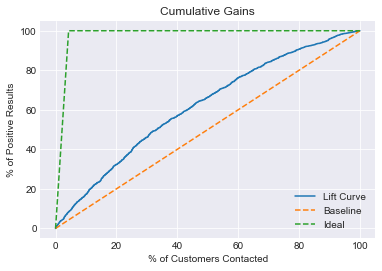

In [22]:
y = label
rfc = RandomForestClassifier(n_estimators=500, max_features=0.95,class_weight=class_weight)
y_proba = cross_val_predict(rfc, X, label, cv=10, n_jobs=-1, method='predict_proba')
results = pd.DataFrame({'y': label, 'y_proba': y_proba[:,1]})
results = results.sort_values(by='y_proba', ascending=False).reset_index(drop=True)
results.index = results.index + 1
results.index = results.index / len(results.index) * 100

sns.set_style('darkgrid')
pred = results
pred['Lift Curve'] = pred.y.cumsum() / pred.y.sum() * 100
pred['Baseline'] = pred.index
base_rate = y.sum() / len(y) * 100
pred[['Lift Curve', 'Baseline']].plot(style=['-', '--', '--'])
pd.Series(data=[0, 100, 100], index=[0, base_rate, 100]).plot(style='--')
plt.title('Cumulative Gains')
plt.xlabel('% of Customers Contacted')
plt.ylabel("% of Positive Results")
plt.legend(['Lift Curve', 'Baseline', 'Ideal'])

In [151]:
ranking_gs = gsear.best_estimator_.feature_importances_[gsear.best_estimator_.feature_importances_ > 0.0009]
np.sort(ranking_gs)[::-1].round(3)

array([0.126, 0.123, 0.078, 0.048, 0.046, 0.035, 0.031, 0.026, 0.025,
       0.024, 0.021, 0.019, 0.018, 0.018, 0.017, 0.017, 0.017, 0.014,
       0.014, 0.014, 0.014, 0.013, 0.013, 0.013, 0.012, 0.012, 0.011,
       0.009, 0.008, 0.008, 0.007, 0.007, 0.007, 0.007, 0.007, 0.005,
       0.005, 0.005, 0.005, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

In [ ]:
print(df2_num.shape,df2_cats.shape)

In [173]:
imp_features = []
for n,i in enumerate(gsear.best_estimator_.feature_importances_):
    if i > 0.0009:
        imp_features.append(n)
imp_features = np.array(imp_features)

In [174]:
X.T[imp_features].T.shape

(34136, 72)

In [194]:
aa = (imp_features[imp_features < 68]).tolist()
num_imp_df = X.T[aa].T

In [199]:
pd.DataFrame(num_imp_df).skew()

0      0.297734
1      0.196168
2      0.408969
3      0.540983
4     -0.686054
5      2.339020
6      1.250027
7      1.439938
8      0.925330
9      6.410508
10     1.422077
11     0.913819
12    -0.158235
13     2.482405
14     1.835796
15     0.925330
16     0.909735
17     2.371158
18     6.410508
19    -1.832300
20     1.018129
21     3.010847
22    10.985968
23     6.405408
24    -0.829300
25     5.950833
26     1.990625
27   -14.553658
28    21.651947
29     0.177599
30     7.656905
31     3.904215
32     2.282161
33     1.778623
34     3.537666
35     2.797726
36     1.834191
37     0.918131
38     0.320933
39     5.959411
40     2.649317
41    -1.629099
42     1.989138
dtype: float64

In [200]:
num_imp.skew()

0      0.297734
1      0.196168
2      0.408969
3      0.540983
4     -0.686054
5      2.339020
6      1.250027
7      1.439938
8      0.925330
9      6.410508
10     1.422077
11     0.913819
12    -0.158235
14     2.482405
15     1.835796
16     0.925330
17     0.909735
18     2.371158
20     6.410508
21    -1.832300
22     1.018129
25     3.010847
26    10.985968
27     6.405408
28    -0.829300
29     5.950833
30     1.990625
31   -14.553658
32    21.651947
34     0.177599
35     7.656905
40     3.904215
41     2.282161
42     1.778623
43     3.537666
44     2.797726
45     1.834191
46     0.918131
47     0.320933
49     5.959411
53     2.649317
58    -1.629099
67     1.989138
dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


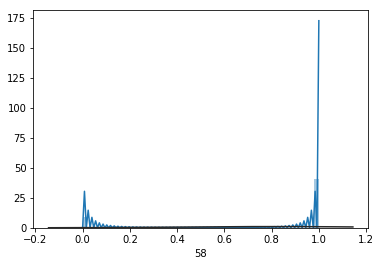

In [221]:
sns.distplot(num_imp[58], fit=norm)

In [152]:
len(ranking_gs)

72

In [153]:
ranking_gs.sum()

0.9535661869412537

In [107]:
clf2 = RandomForestClassifier(max_depth= None, n_estimators= 500)
cross_val_score(clf2 , X_p , label,scoring='roc_auc',cv = 3)

array([0.53811577, 0.57721066, 0.54921834])

In [123]:
clf3 = RandomForestClassifier(max_depth =  2, max_features = 70, n_estimators = 110, class_weight=class_weight)
cross_val_score(clf3 , X_p , label,scoring='roc_auc',cv = 3)

array([0.60432312, 0.61917173, 0.61419288])

In [113]:
clf4 = RandomForestClassifier(max_depth =  3, max_features = 70, n_estimators = 100)
cross_val_score(clf4 , X_p , label,scoring='roc_auc',cv = 3)

array([0.58678465, 0.60647965, 0.59365488])

In [111]:
clf3.fit(X_train,y_train)
clf3.feature_importances_

array([0.00315057, 0.00239347, 0.        , 0.01386755, 0.        ,
       0.43454928, 0.00128032, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03068879,
       0.        , 0.        , 0.        , 0.        , 0.00170602,
       0.        , 0.00903602, 0.        , 0.        , 0.        ,
       0.06373087, 0.        , 0.        , 0.00210846, 0.        ,
       0.        , 0.        , 0.00310375, 0.        , 0.00206516,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0391864 , 0.        , 0.00467826, 0.        ,
       0.03730883, 0.04616455, 0.00615926, 0.        , 0.        ,
       0.        , 0.02412081, 0.        , 0.        , 0.00158778,
       0.        , 0.        , 0.        , 0.00344985, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00586076, 0.        , 0.09837892, 0.01175676, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [120]:
rankings = clf3.feature_importances_[clf3.feature_importances_ > 0.00001]
np.sort(rankings)[::-1]

array([0.43454928, 0.09837892, 0.06373087, 0.04616455, 0.0391864 ,
       0.03811072, 0.03730883, 0.03068879, 0.02708941, 0.02412081,
       0.01409254, 0.01386755, 0.01175676, 0.00903602, 0.0077224 ,
       0.00765958, 0.00660656, 0.00615926, 0.00604407, 0.00586076,
       0.00532511, 0.00467826, 0.0044973 , 0.004482  , 0.00344985,
       0.00315057, 0.00310375, 0.00268352, 0.00246634, 0.00239347,
       0.00237637, 0.00233176, 0.00225018, 0.0022068 , 0.00210846,
       0.00206516, 0.00206232, 0.00184679, 0.0018273 , 0.00175665,
       0.00170602, 0.00159652, 0.00158778, 0.00153003, 0.00149231,
       0.00147282, 0.00139021, 0.00128032, 0.00114421, 0.00083949,
       0.00076425])

In [37]:
from keras import layers, models
from keras.callbacks import EarlyStopping

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [76]:
model1 = models.Sequential()
model1.add(layers.Dense(512,activation='relu',input_shape = (494,)))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(128,activation= 'relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='Adam', metrics =['acc'])

In [77]:
history = model1.fit( X,label.values ,epochs=100, validation_split=0.3,class_weight=class_weight)

Train on 23895 samples, validate on 10241 samples
Epoch 1/100
23895/23895 [==============================] - 8s 336us/step - loss: 1.3623 - acc: 0.3820 - val_loss: 1.3980 - val_acc: 0.8938
Epoch 2/100
23895/23895 [==============================] - 7s 297us/step - loss: 1.3189 - acc: 0.4763 - val_loss: 1.3815 - val_acc: 0.6890
Epoch 3/100
23895/23895 [==============================] - 8s 335us/step - loss: 1.2955 - acc: 0.5262 - val_loss: 1.3755 - val_acc: 0.5585
Epoch 4/100
23895/23895 [==============================] - 9s 370us/step - loss: 1.2676 - acc: 0.5515 - val_loss: 1.4020 - val_acc: 0.5508
Epoch 5/100
23895/23895 [==============================] - 8s 330us/step - loss: 1.2284 - acc: 0.5693 - val_loss: 1.4232 - val_acc: 0.5645
Epoch 6/100
23895/23895 [==============================] - 8s 325us/step - loss: 1.2093 - acc: 0.5743 - val_loss: 1.4279 - val_acc: 0.5661
Epoch 7/100
23895/23895 [==============================] - 8s 328us/step - loss: 1.1923 - acc: 0.5865 - val_loss: 1.

23895/23895 [==============================] - 8s 331us/step - loss: 0.2470 - acc: 0.9430 - val_loss: 4.8920 - val_acc: 0.8413
Epoch 60/100
23895/23895 [==============================] - 8s 354us/step - loss: 0.2797 - acc: 0.9402 - val_loss: 4.9479 - val_acc: 0.8889
Epoch 61/100
23895/23895 [==============================] - 10s 399us/step - loss: 0.2718 - acc: 0.9409 - val_loss: 4.8345 - val_acc: 0.8607
Epoch 62/100
23895/23895 [==============================] - 8s 335us/step - loss: 0.2635 - acc: 0.9419 - val_loss: 5.0848 - val_acc: 0.8583
Epoch 63/100
23895/23895 [==============================] - 8s 319us/step - loss: 0.2533 - acc: 0.9427 - val_loss: 4.9615 - val_acc: 0.8999
Epoch 64/100
23895/23895 [==============================] - 8s 320us/step - loss: 0.2819 - acc: 0.9400 - val_loss: 5.1893 - val_acc: 0.8875
Epoch 65/100
23895/23895 [==============================] - 9s 359us/step - loss: 0.2335 - acc: 0.9457 - val_loss: 5.7635 - val_acc: 0.8977
Epoch 66/100
23895/23895 [======

In [63]:
#unable to reach 

{0: 1.0, 1: 23.3}

In [178]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))